In [30]:
# Importing dependencies
import pandas as pd
import os
import numpy as np
from datetime import datetime
from typing import List, Union, Iterator, Tuple
from glob import glob
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Flatten
from keras.models import Sequential
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import History, TensorBoard
from keras import Model
from keras.optimizers import Adam

## Reading data

In [3]:
data_path = '/Users/rahuln/PycharmProjects/PiCarNet/machine-learning-in-science-ii-2023'

In [4]:
def load_data(data_path: str) -> pd.DataFrame:
    """Loads data from csv file
    Params
    ------
    data_path: str
        Data path containing images and csv data
    Returns
    -------
    pd.DataFrame
        Loaded data as pandas dataframe
    """
    columns = ['image_id', 'angle', 'speed']
    data = pd.read_csv(os.path.join(data_path, 'training_norm.csv'), delimiter= ',', header=0, names = columns)

    return data

In [5]:
data = load_data(data_path)

In [6]:
data.head(5)

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [7]:
data['image_id'] = data.image_id.apply(lambda x: os.path.join(data_path, 'training_data/', str(x)) + '.png')

In [8]:
data.head()

,image_id,angle,speed
0,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.4375,0.0
1,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.8125,1.0
2,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.4375,1.0
3,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.6250,1.0
4,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.5000,0.0


## Data preprocessing

In [9]:
# train test split of dataset
def split_data(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Params
    ------
    data: pd.DataFrame
        Pandas dataframe containing all data.
    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of train, test and val split
    """
    rnd = np.random.RandomState(seed=None)

    #train_data = data.sample(frac=0.7, random_state=rnd)
    #test_data = data.loc[~data.index.isin(train_data.index)]
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=rnd.seed(1234)) # split data with test size of 20%

    return train_data, val_data

In [10]:
train_data,  val_data = split_data(data)

In [11]:
val_data['image_id'].tolist()[1]

'/Users/rahuln/PycharmProjects/PiCarNet/machine-learning-in-science-ii-2023/training_data/8095.png'

In [12]:
# plotting distribution of output labels
def visualize(data):
    plt.hist(data.loc[:,'angle'])
    plt.hist(data.loc[:,'speed'])
    plt.legend(['Steering angle', 'Driving speed'])
    plt.title('Distribution plot for steering angle and speed')
    plt.grid(False)
    plt.show()

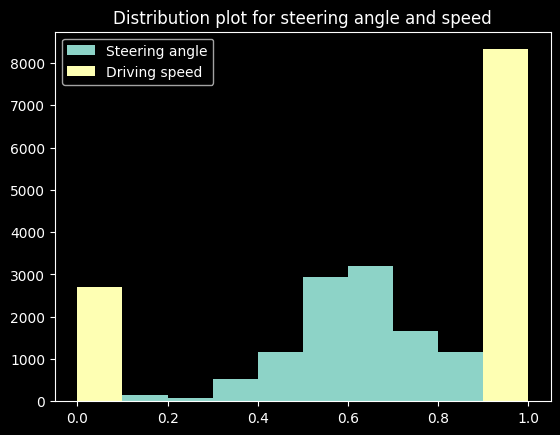

In [13]:
visualize(data=train_data)

## Data pipeline

In [14]:
# Generate images on the fly while training model
def img_generator(train_data: pd.DataFrame, val_data: pd.DataFrame, test_dir: os.PathLike, BATCH_SIZE: int, IMG_HEIGHT: int, IMG_WIDTH: int) -> Tuple[Iterator, Iterator, Iterator]:
    """
    Params
    ------
    train_data: pd.DataFrame
        Pandas dataframe containing training data
    val_data: pd.DataFrame
        Pandas dataframe containing validation data
    test_dir: os.PathLike
        path to test data directory
    BATCH_SIZE: int
        Number of images to process in each batch
    IMG_HEIGHT: int
        image height
    IMG_WIDTH: int
        image width

    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, testing and validating model.
    """

    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=False,
        validation_split=0.2)

    val_generator = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_generator.flow_from_dataframe(dataframe=train_data,
                                                          directory=None,
                                                          x_col='image_id',
                                                          y_col=['angle','speed'],
                                                          color_mode='rgb',
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          class_mode='raw',
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True)
    
    val_generator = val_generator.flow_from_dataframe(dataframe=val_data,
                                               x_col='image_id',
                                               y_col=['angle', 'speed'],
                                               class_mode='raw',
                                               color_mode='rgb',
                                               target_size=(224, 224),
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)
    
    test_generator = test_generator.flow_from_directory(
        directory=test_dir,  # test_dir should contain a sub dir images
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='rgb',
        class_mode=None,
        classes=None,
        batch_size=BATCH_SIZE,
        seed=1234,
        shuffle=False)



    return train_generator, val_generator, test_generator


In [15]:
# create base model using transfer learning
def create_baseline_model(input_shape, dropout_rate, optimizer) -> Sequential:
    """Creates a baseline model from MobileNetV2

    Params
    ------
    input_shape: input dimensions of image (224x224x3).
    dropout_rate: Applies Dropout to the input, to prevent over-fitting.
    optimizer: Optimization algorithm.

    Returns
    -------
    Sequential
        The keras model.
    """
    mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    mobilenet.trainable = False # Freeze the model

    # Rebuild top
    model = Sequential([
        mobilenet,
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(48, activation='softmax'),
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        BatchNormalization(),
        Dropout(dropout_rate),
        Flatten(),
        Dense(2, activation='linear')
    ], name='baseline')

    model.compile(loss=['mean_squared_error'], optimizer=optimizer, metrics=['mse', 'accuracy'])
    return model

# NOTE: we might need more complex model suggested by NVIDIA
# ref: https://towardsdatascience.com/teaching-cars-to-drive-using-deep-learning-steering-angle-prediction-5773154608f2

In [16]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
BATCH_SIZE=64
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

lr = 1e-3 # learning rate
#decay = 0.01 # weight decay
dropout_rate = 0.1
optimizer = Adam(learning_rate=lr)  # optimizer

baseline_model = create_baseline_model(input_shape, dropout_rate, optimizer)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-15 22:06:39.788873: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-15 22:06:39.788903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
baseline_model.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1280)       5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 dense (Dense)               (None, 7, 7, 48)          61488     
                                                                 
 global_average_pooling2d (G  (None, 48)               0         
 lobalAveragePooling2D)                                          
                                                          

In [18]:
test_dir = os.path.join(data_path, 'test_data')
train_generator, val_generator, test_generator, = img_generator(train_data, val_data, test_dir, BATCH_SIZE=64, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH)

Found 11034 validated image filenames.
Found 2759 validated image filenames.
Found 1020 images belonging to 1 classes.


In [19]:
# defining callbacks
def get_callbacks(model: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple keras callbacks

    Params
    ------
    model: str
        The name of model as a string

    Returns
    -------
    A list of multiple keras callbacks
    """
    logdir = (
        'logs/scalars/' + model + '_' + datetime.now().strftime('%Y%m%d-%H%M%S')
    ) # logging for each model
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    early_stopping_callback = EarlyStopping(
        monitor='mse',
        min_delta=0.01,  # model should improve by at least 0.01
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=1,
        mode='min',
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        './data/models/' + model + '.h5',
        monitor='mse',
        verbose=0,
        save_best_only=True,  # save the best model
        mode='min',
        save_freq='epoch',  # save the model on disk at end of every epoch
    )
    return [model_checkpoint_callback, tensorboard_callback, early_stopping_callback]

In [20]:
tf.keras.backend.clear_session() # clear keras session

## Training model

In [21]:
## Train model
def train(name: str, model: Model, train_generator: Iterator, val_generator: Iterator, epoch: int) -> History:
    """
    Params
    ------
    name: str
        Model name
    model: keras.models.Model
        Model we are training
    train_generator: Iterator
        Image data generator for training
    val_generator: Iterator
        Image data generator for validation
    epoch: int
        Number of epochs to train for
    Returns
    -------
    keras.callbacks.History
    """
    callbacks = get_callbacks(name)

    history = model.fit(train_generator,
              epochs=epoch,
              steps_per_epoch=400,
              validation_data=val_generator,
              validation_steps=200,
              callbacks=callbacks,
              workers=4,
              verbose=1,
              batch_size=64)

    return history

In [22]:
baseline_history = train(name='baseline', model=baseline_model, train_generator=train_generator, val_generator=val_generator, epoch=50)

Epoch 1/50


2023-03-15 22:06:42.030352: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-15 22:06:43.427572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - ETA: 0s - loss: 0.0693 - mse: 0.0693 - accuracy: 0.9054

2023-03-15 22:08:00.981110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 100s 243ms/step - loss: 0.0693 - mse: 0.0693 - accuracy: 0.9054 - val_loss: 0.0906 - val_mse: 0.0906 - val_accuracy: 0.9507
Epoch 2/50
400/400 [==============================] - 95s 236ms/step - loss: 0.0253 - mse: 0.0253 - accuracy: 0.9539 - val_loss: 0.0401 - val_mse: 0.0401 - val_accuracy: 0.9253
Epoch 3/50
400/400 [==============================] - 94s 234ms/step - loss: 0.0213 - mse: 0.0213 - accuracy: 0.9613 - val_loss: 0.0380 - val_mse: 0.0380 - val_accuracy: 0.9042
Epoch 4/50
400/400 [==============================] - 94s 235ms/step - loss: 0.0190 - mse: 0.0190 - accuracy: 0.9668 - val_loss: 0.0291 - val_mse: 0.0291 - val_accuracy: 0.9430
Epoch 5/50
400/400 [==============================] - 96s 238ms/step - loss: 0.0176 - mse: 0.0176 - accuracy: 0.9703 - val_loss: 0.0260 - val_mse: 0.0260 - val_accuracy: 0.9434
Epoch 6/50
400/400 [==============================] - 95s 235ms/step - loss: 0.0171 - mse: 0.0171 - accuracy: 0.9702 - val_lo

## Evaluating model performance

In [28]:
# Plot training and validation loss
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'lightblue', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'coral', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Baseline model: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(False)
    plt.legend()
    plt.savefig('baseline_plot.pdf')
    plt.show()

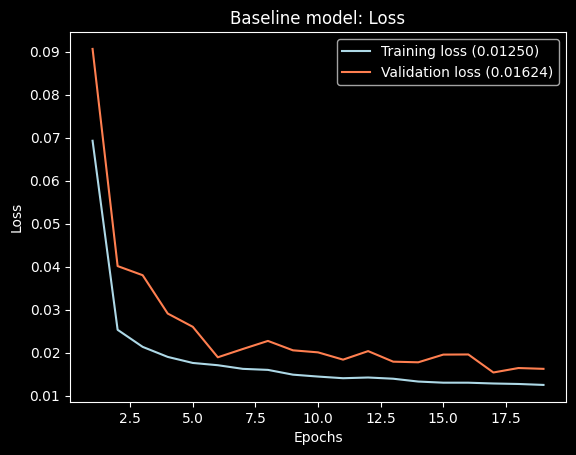

In [29]:
plot_history(baseline_history)

## Making prediction

In [33]:
def get_predictions(test_path: os.PathLike, test_generator: Iterator, model: Sequential) -> pd.DataFrame:
    """
    Params
    ------
    test_path: os.PathLike
        path to test data
    test_generator: Iterator
        data generator for testing
    model: Sequential model
        trained model to make

    Returns
    -------
    pd.DataFrame
        predictions as pandas dataframe
    """

    # list of all png files in test data
    png_files = glob(f'{test_dir}/*png')

    # convert to pandas dataframe with image_id as column name
    png_df = pd.DataFrame(data=png_files, columns=['image_id'])
    png_df['image_id'] = png_df.image_id.apply(lambda x: os.path.split(x)[-1].split('.png')[0])

    # make predictions
    pred = model.predict(test_generator)

    # convert prediction numpy.ndarray( to pd.DataFrame
    pred_df = pd.concat([png_df, pd.DataFrame(data=pred, columns=['angle', 'speed'])], axis=1)
    # dropping index from dataframe
    pred_df.reset_index(drop=True)

    # return predictions
    return pred_df

In [34]:
def save_csv(pred_df: pd.DataFrame) -> None:
    """
    Params
    ------
    pred_df: pd.DataFrame
        predictions in pandas dataframe

    Returns
    -------
    None
    """

    savedir='./submissions' # submissions directory
    if not os.path.exists(savedir):
        os.mkdir(savedir)

    csvfile = 'submission' + '_' + datetime.now().strftime('%d-%b_%I-%M%p') + '.csv' # csv file name
    savedir = str(os.path.join(savedir, csvfile))
    pred_df.to_csv(savedir, sep=',', index=False) # save to disk
    print('Saved CSV file on disk!')

In [35]:
test_path = os.path.join('test_data', 'images') # path to test data
pred_df = get_predictions(test_path, test_generator, baseline_model)

16/16 [==============================] - 4s 228ms/step


In [36]:
save_csv(pred_df)

Saved CSV file on disk!
